In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os, sys 
sys.path.append('../../src')

In [3]:
from spaceoracle.tools.network import HumanTonsilRegulatoryNetwork
co_grn = HumanTonsilRegulatoryNetwork()

In [4]:
adata = sc.read_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')
adata

AnnData object with n_obs × n_vars = 5778 × 3163
    obs: 'cell_type', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts', 'cell_type_int'
    var: 'MT', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg'
    obsm: 'spatial'
    layers: 'normalized_count'

In [5]:
adata.var_names

Index(['LINC01128', 'TNFRSF4', 'MRPL20-AS1', 'MRPL20', 'SKI', 'PLCH2',
       'PRXL2B', 'TTC34', 'MEGF6', 'TPRG1L',
       ...
       'GAB3', 'F8', 'F8A1', 'CLIC2', 'TMLHE-AS1', 'LINC00278', 'PCDH11Y',
       'NLGN4Y', 'TTTY14', 'TTTY10'],
      dtype='object', name='Unnamed: 0', length=3163)

In [6]:
from spaceoracle.oracles import SpaceTravLR

star = SpaceTravLR(
    adata, 
    save_dir='./models',
    annot='cell_type_int',
    grn=co_grn
)

star.adata

Calculating MAGIC...
  Running MAGIC on 5778 cells and 3163 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 1.31 seconds.
    Calculating KNN search...
    Calculated KNN search in 1.78 seconds.
    Calculating affinities...
    Calculated affinities in 1.57 seconds.
  Calculated graph and diffusion operator in 4.67 seconds.
  Calculating imputation...
  Calculated imputation in 0.46 seconds.
Calculated MAGIC in 5.15 seconds.


AnnData object with n_obs × n_vars = 5778 × 3163
    obsm: 'spatial'
    layers: 'normalized_count', 'imputed_count'

In [7]:
adata.layers['imputed_count'] = star.adata.layers['imputed_count'].copy()

In [36]:
from spaceoracle.models.parallel_estimators import SpatialCellularProgramsEstimator

# test run to make sure everything is working

estimator = SpatialCellularProgramsEstimator(
    adata=adata,
    target_gene='FOXO1',
    layer='imputed_count',
    cluster_annot='cell_type_int', 
    grn=co_grn,
    species='human'
)

In [63]:
# estimator.plot_modulators()

In [64]:
estimator.fit(num_epochs=200, threshold_lambda=1e-8, learning_rate=5e-4)

Fitting FOXO1 with 152 modulators
	27 Transcription Factors
	65 Ligand-Receptor Pairs
	60 TranscriptionFactor-Ligand Pairs
0: 0.9169 | 0.7526
1: 0.7094 | 0.6929
2: 0.8981 | 0.7757
3: 0.9576 | -0.6646
4: 0.9214 | 0.6887
5: 0.7782 | 0.6722
6: 0.8886 | 0.7945
7: 0.9990 | 0.9073
8: 0.9081 | 0.8556
9: 0.9663 | 0.9311
10: 0.9832 | -0.1121
11: 0.9981 | 0.9772
12: 0.9245 | -7.2873


In [67]:
estimator.betadata.to_parquet(f'./models/{estimator.target_gene}_betadata.parquet')

In [68]:
so = SpaceTravLR(adata=estimator.adata, save_dir = './models')
gene_mtx = so.adata.layers[estimator.layer]
beta_dict = {estimator.target_gene: so._get_betas(estimator.target_gene)}

gex_df = estimator.adata.to_df(layer=estimator.layer)
beta_dict = so._get_wbetas_dict(beta_dict, gex_df)
wbetas = beta_dict[estimator.target_gene].wbetas[1]

xy = pd.DataFrame(
    estimator.adata.obsm['spatial'], index=estimator.adata.obs.index, columns=['x', 'y'])

df = wbetas \
        .join(estimator.adata.obs) \
        .join(xy) \
        .join(gex_df)

In [69]:
df[[i for i in df.columns if 'beta_' in i]].var(0).sort_values()

beta_ACVR1C     0.000000e+00
beta_CD44       0.000000e+00
beta_CCL4       1.106990e-09
beta_ANGPTL1    3.579308e-09
beta_NRG2       3.008261e-08
                    ...     
beta_EGR3       1.496866e+00
beta_KLF3       2.076098e+00
beta_NR4A2      2.534599e+00
beta_FOXP3      2.888569e+00
beta_PDGFRB     1.263991e+01
Length: 119, dtype: float64

<Axes: xlabel='x', ylabel='y'>

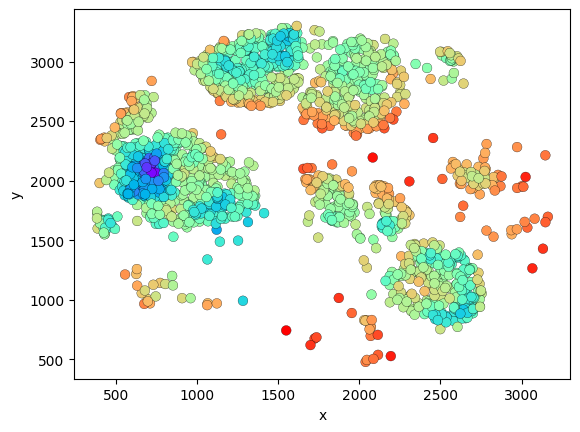

In [76]:
sns.scatterplot(
    data=df[df['cell_type'] == 'B_germinal_center'],
    x='x', 
    y='y',
    hue='beta_NR4A2',
    palette='rainbow',
    s=50,
    linewidth=0.2,
    edgecolor='black',
    legend=False,
)

In [105]:
df['cell_type'].value_counts()

cell_type
B_germinal_center      1848
B_naive                1067
T_CD4                   779
B_memory                516
T_follicular_helper     294
plasma                  262
FDC                     255
T_CD8                   238
NK                      170
mDC                     137
myeloid                 102
pDC                      64
T_double_neg             46
Name: count, dtype: int64

In [83]:
adata.obs = adata.obs.drop(columns=['n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 'n_counts'])

In [84]:
adata.layers['imputed_count'] = star.adata.layers['imputed_count']
adata.write_h5ad('/Users/koush/Projects/SpaceOracle/data/slidetags/snrna_human_tonsil.h5ad')

see train.py and submit with run.sh